## Notes on COVID-19 Modeling

Description


In [2]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

Epidemic Modeling 101: Or Why Your CoVID19 Exponential Fits Are Wrong. https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8. Accessed 30 Mar. 2020.

Linton, Natalie M., et al. “Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data.” Journal of Clinical Medicine, vol. 9, no. 2, 2, Multidisciplinary Digital Publishing Institute, Feb. 2020, p. 538. www.mdpi.com, doi:10.3390/jcm9020538.





There are four distributions that are used to fit to the cumulative number of cases or deaths. Are the really much different?

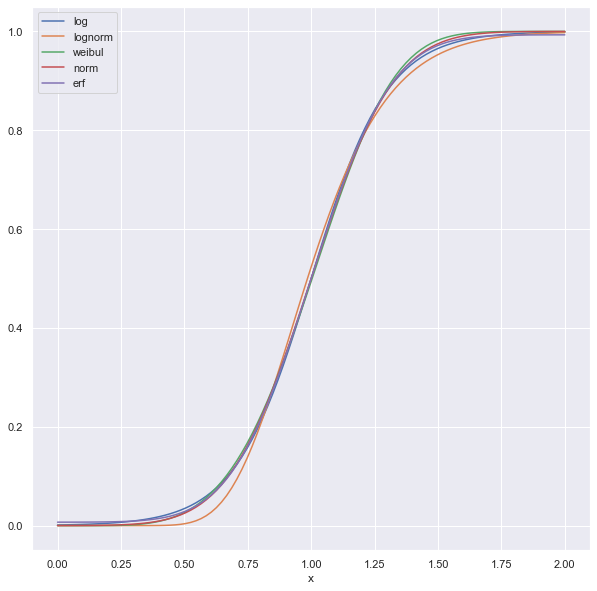

In [168]:
##
## Create a base logistic function, centered at 1, 
## then fit other distributions to it. 
##

from scipy.stats import weibull_min, lognorm, logistic, norm

x = np.linspace(0,2, 100)

#
# Logistic
#
def func_logistic(x, loc, scale):
    return logistic.cdf(x, loc, scale)

#popt, pcov = curve_fit(func_logistic, x, wd, p0=(.8,.2))
popt = (1,.15)
logd = func_logistic(x, *popt)

base_dist = logd

#
# Weibul
#

def func_weibull(x, loc ,scale):
    return weibull_min.cdf(x,loc, scale)

popt, pcov = curve_fit(func_weibull, x, base_dist, p0=(4,0))

wd = func_weibull(x, *popt)


#
# Lognorm
#

def func_ln(x, loc, scale):
    return lognorm.cdf(x, loc, scale)

popt, pcov = curve_fit(func_ln, x, base_dist, p0=(.3,0))

lnd = func_ln(x, *popt)

#
# Normal
#

def func_norm(x, loc, scale):
    return norm.cdf(x, loc, scale)

popt, pcov = curve_fit(func_norm, x, base_dist, p0=(1,.15))

normd = func_norm(x, *popt)


#
# Error Function
#

def func_erf(x, a, b):
    r =  a*erf(b*(x-1)) + .5
    
    return r

popt, pcov = curve_fit(func_erf, x, base_dist, p0=(.5, 10))

erfd = func_erf(x, *popt)


#ax.set_xlim((1, 1.50))
#ax.set_ylim((.8, 1))

cdf = pd.DataFrame({
    'x': x,
    'log': logd, 
    'lognorm': lnd,
    'weibul': wd,
    'norm': normd, 
    'erf': erfd
}).set_index('x')

fig, ax = plt.subplots(1, 1, figsize=(10,10))

cdf.plot(ax=ax)


In [170]:
cdf.corr()

,log,lognorm,weibul,norm,erf
log,1.000000,0.999399,0.999838,0.999922,0.999946
lognorm,0.999399,1.000000,0.999106,0.999411,0.999453
weibul,0.999838,0.999106,1.000000,0.999964,0.999923
norm,0.999922,0.999411,0.999964,1.000000,0.999975
erf,0.999946,0.999453,0.999923,0.999975,1.000000


In [222]:
# Compare the similarities of the distibutions. The 
# Kologorov-Smirnov test assesses how likely is it that
# two sets of samples were drawn from the same distribution. 
# https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
from scipy.stats import ks_2samp

dist = pdf

index = [] 
for a,b in dist.corr().stack().index: # Cheap way to generate all combinations
    idx = tuple(sorted([a,b]))
    if idx in index: # or a == b:
        continue
    else:
        index.append(idx)

df = pd.DataFrame(index=pd.MultiIndex.from_tuples(index, names=['a', 'b']))
df['ks_mean'] = np.nan 
df['ks_p'] = np.nan 
    
for idx in df.index:
   
    try:
        v = ks_2samp(dist[idx[0]],dist[idx[1]])
    except KeyError:
        print(a, b)
        pass
    
    df.at[idx,'ks_stat']  = v[0]
    df.at[idx,'ks_p'] = v[1]
    
    
df

ks_mean      ks_p  ks_stat
a       b                                  
log     log          NaN  1.000000     0.00
        lognorm      NaN  0.015577     0.22
        weibul       NaN  0.000738     0.28
        norm         NaN  0.015577     0.22
lognorm lognorm      NaN  1.000000     0.00
        weibul       NaN  0.815415     0.09
        norm         NaN  0.078221     0.18
weibul  weibul       NaN  1.000000     0.00
norm    weibul       NaN  0.154839     0.16
        norm         NaN  1.000000     0.00

In [217]:
pdf.columns

Index(['log', 'lognorm', 'weibul', 'norm'], dtype='object')

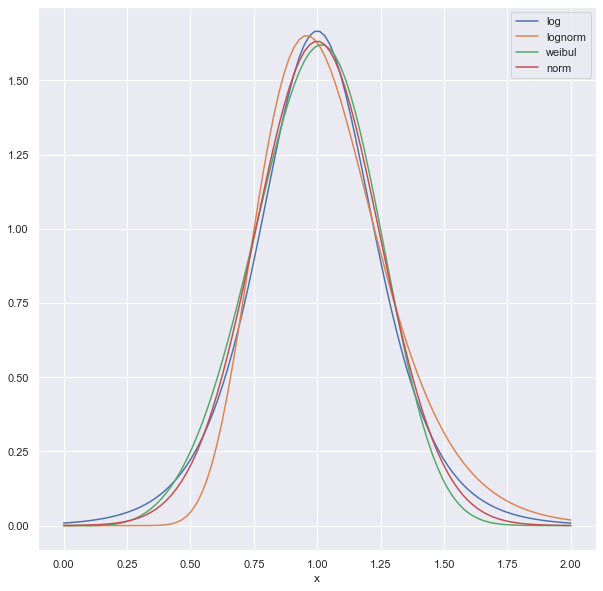

In [145]:
##
## Create a base logistic function, centered at 1, 
## then fit other distributions to it. 
##

from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy import special


x = np.linspace(0,2, 100)


#
# Logistic
#
def func_logistic(x, loc, scale):
    return logistic.pdf(x, loc, scale)

#popt, pcov = curve_fit(func_logistic, x, wd, p0=(.8,.2))
popt = (1,.15)
logd = func_logistic(x, *popt)

base_dist = logd

#
# Weibul
#

def func_weibull(x, loc ,scale):
    return weibull_min.pdf(x,loc, scale)

popt, pcov = curve_fit(func_weibull, x, base_dist, p0=(4,0))

wd = func_weibull(x, *popt)

#
# Lognorm
#

def func_ln(x, loc, scale):
    return lognorm.pdf(x, loc, scale)

popt, pcov = curve_fit(func_ln, x, base_dist, p0=(.3,0))

lnd = func_ln(x, *popt)


#
# Error Function
# Is there a "pdf" version of erf?

#
# Normal
#

def func_norm(x, loc, scale):
    return norm.pdf(x, loc, scale)

popt, pcov = curve_fit(func_norm, x, base_dist, p0=popt)

normd = func_norm(x, *popt)


pdf = pd.DataFrame({
    'x': x,
    'log': logd, 
    'lognorm': lnd,
    'weibul': wd,
    'norm': normd
   
}).set_index('x')

fig, ax = plt.subplots(1, 1, figsize=(10,10))
pdf.plot(ax=ax)


,log,lognorm,weibul,norm
log,1.000000,0.989137,0.996077,0.998279
lognorm,0.989137,1.000000,0.981527,0.989740
weibul,0.996077,0.981527,1.000000,0.998701
norm,0.998279,0.989740,0.998701,1.000000


In [142]:
cdf.sum()/len(cdf)


log        0.500000
lognorm    0.492044
weibul     0.501407
erf        0.500000
dtype: float64

In [143]:
pdf.sum()/len(pdf)

log        0.493824
lognorm    0.493583
weibul     0.495000
dtype: float64

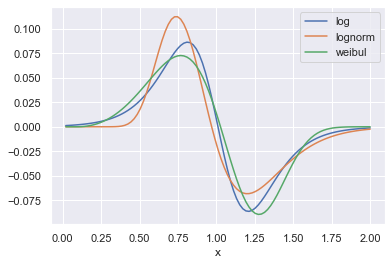

In [144]:
pdf.diff().plot()